<a href="https://colab.research.google.com/github/aliakbarbadri/natural-language-inference/blob/master/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import tensorflow_addons as tfa

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


# Load and Preprocess the data

In [2]:
source = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/premises_train.pickle?raw=true')
target = pd.read_pickle(r'https://github.com/aliakbarbadri/natural-language-inference/blob/master/hypotheses_train.pickle?raw=true')

In [3]:
print(source[0])
print(target[0])

A person on a horse jumps over a broken down airplane .
A person is outdoors , on a horse .


In [4]:
lines_main = pd.DataFrame(
    {'source': source,
     'target': target
     })

In [5]:
lines_main.shape

(183416, 2)

In [6]:
lines = lines_main[:50000]

In [7]:
lines.shape

(50000, 2)

In [8]:
# Lowercase all characters
lines.source=lines.source.apply(lambda x: x.lower())
lines.target=lines.target.apply(lambda x: x.lower())

# Remove quotes
lines.source=lines.source.apply(lambda x: re.sub("'", '', x))
lines.target=lines.target.apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.source=lines.source.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.target=lines.target.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.source=lines.source.apply(lambda x: x.translate(remove_digits))
lines.target=lines.target.apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines.source=lines.source.apply(lambda x: x.strip())
lines.target=lines.target.apply(lambda x: x.strip())
lines.source=lines.source.apply(lambda x: re.sub(" +", " ", x))
lines.target=lines.target.apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines.target = lines.target.apply(lambda x : 'START_ '+ x + ' _END')

lines.sample(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,source,target
39674,girl getting her hair dyed,START_ the girl is changing her hair color _END
18737,a girl n an orange dress rides a bicycle on an...,START_ there is only one person _END
15700,two men fly fishing while standing in a river,START_ two men are standing in the river _END
32658,three elderly men look at books on display in ...,START_ three old guys peruse the books _END
29884,three people hiking on a beach,START_ people are hiking on a beach _END
38822,a dog stands in deep snow surrounded by trees,START_ a dog is outside _END
41504,a dog jumps over a hurdle in the grass,START_ a dog jumping over a hurdle _END
29120,a teen boy with a black shirt and blue jeans p...,START_ a person is on a bike _END
20918,three people sit at a table in front of an est...,START_ the people are outside _END
8461,a man and a woman standing outside a restaurant,START_ a man and women stand outside a restaur...


In [9]:
all_words_source=set()
for line in lines.source:
    for word in line.split():
        if word not in all_words_source:
            all_words_source.add(word)

all_words_target=set()
for line in lines.target:
    for word in line.split():
        if word not in all_words_target:
            all_words_target.add(word)

In [10]:
lenght_list=[]
for l in lines.source:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)

lenght_list=[]
for l in lines.target:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)

max_length_src, max_length_tar

(78, 45)

In [11]:
input_words = sorted(list(all_words_source))
target_words = sorted(list(all_words_target))

num_encoder_tokens = len(all_words_source)#+1
num_decoder_tokens = len(all_words_target)+1

num_encoder_tokens, num_decoder_tokens

(11410, 8694)

In [12]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [13]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [14]:
# lines = shuffle(lines)
lines.head(10)

,source,target
0,a person on a horse jumps over a broken down a...,START_ a person is outdoors on a horse _END
1,children smiling and waving at camera,START_ there are children present _END
2,a boy is jumping on skateboard in the middle o...,START_ the boy does a skateboarding trick _END
3,two blond women are hugging one another,START_ there are women showing affection _END
4,a few people in a restaurant setting one of th...,START_ the diners are at a restaurant _END
5,an older man is drinking orange juice at a res...,START_ a man is drinking juice _END
6,a man with blondhair and a brown shirt drinkin...,START_ a blond man drinking water from a fount...
7,two women who just had lunch hugging and sayin...,START_ there are two woman in this picture _END
8,two women holding food carryout containers hug,START_ two women hug each other _END
9,a little league team tries to catch a runner s...,START_ a team is trying to tag a runner out _END


In [15]:
# Train - Test Split
X, y = lines.source, lines.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape

((40000,), (10000,))

In [16]:
# X_train.to_pickle('X_train.pkl')
# X_test.to_pickle('X_test.pkl')

In [17]:
def generate_batch(X = X_train, y = y_train, batch_size = 64):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Model

In [18]:
latent_dim = 256

In [19]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# # Encoder
# encoder_inputs = Input(shape=(None,))
# enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
# encoder_lstm = LSTM(latent_dim, return_state=True)
# encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# # We discard `encoder_outputs` and only keep the states.
# encoder_states = [state_h, state_c]

In [20]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [21]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2920960     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    2225664     input_2[0][0]                    
____________________________________________________________________________________________

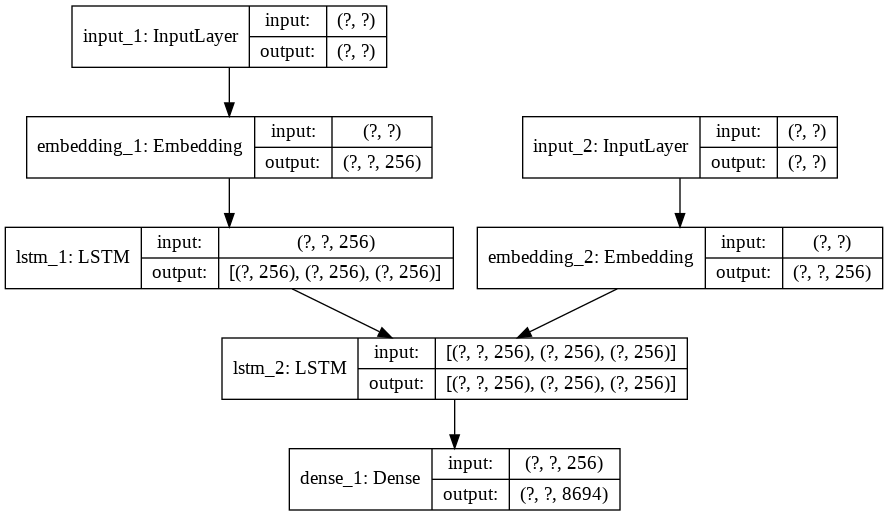

In [22]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [23]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 32
epochs = 7

In [24]:
history = model.fit(generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/7
1250/1250 [==============================] - 780s 624ms/step - loss: 0.6541 - acc: 0.3605 - val_loss: 0.6650 - val_acc: 0.4152
Epoch 2/7
1250/1250 [==============================] - 772s 617ms/step - loss: 0.5556 - acc: 0.4349 - val_loss: 0.5873 - val_acc: 0.4456
Epoch 3/7
1250/1250 [==============================] - 734s 587ms/step - loss: 0.5181 - acc: 0.4596 - val_loss: 0.4937 - val_acc: 0.4616
Epoch 4/7
1250/1250 [==============================] - 722s 578ms/step - loss: 0.4906 - acc: 0.4773 - val_loss: 0.4887 - val_acc: 0.4714
Epoch 5/7
1250/1250 [==============================] - 714s 571ms/step - loss: 0.4695 - acc: 0.4933 - val_loss: 0.5577 - val_acc: 0.4778
Epoch 6/7
1250/1250 [==============================] - 709s 567ms/step - loss: 0.4527 - acc: 0.5069 - val_loss: 0.4878 - val_acc: 0.4817
Epoch 7/7
1250/1250 [==============================] - 708s 566ms/step - loss: 0.4387 - acc: 0.5193 - val_loss: 0.4667 - val_acc: 0.4810


In [25]:
# model = keras.models.load_model('seq2seq_model.h5')
model = model.load_weights('seq_weights.h5')
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")
# print("Saved model to disk")

In [26]:
model.save('seq_model.h5')
# model.save_weights('seq_weights.h5')
# load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()

# Loss and Acc. graph

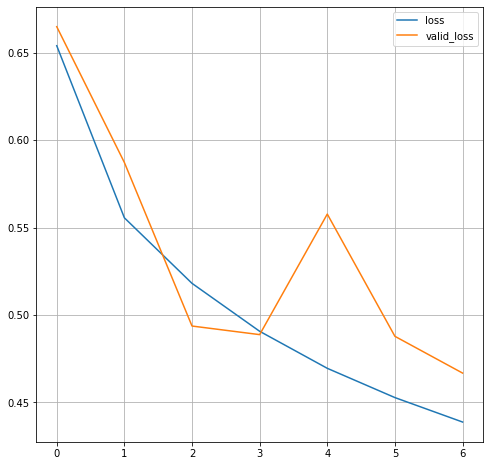

In [27]:
pd.DataFrame({'loss':history.history['loss'],
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))
plt.grid(True)

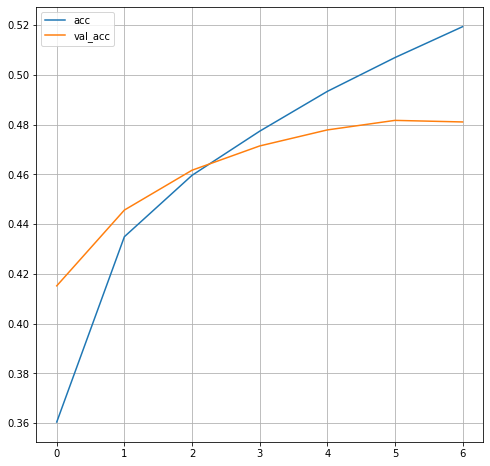

In [28]:
pd.DataFrame({'acc':history.history['acc'],
              'val_acc':history.history['val_acc']
              }).plot(figsize=(8, 8))
plt.grid(True)


# Model Evaluation

In [29]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [30]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_token_index['START_']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence

In [44]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [38]:
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input:', X_test[k:k+1].values[0])
print('Actual:', y_test[k:k+1].values[0][6:-4])
print('Predicted:', decoded_sentence[:-4])

Input: a man drives a truck while a child sits on his lap and steers
Actual:  a small child sits on a mans lap and steers a truck 
Predicted:  a man is sitting on a couch 


In [40]:
# just to see why use 6, -4
print(y_test[k:k+1].values[0])
print(y_test[k:k+1].values[0][6:-4].split())
print()
print(decoded_sentence)
print(decoded_sentence[:-4].split())

START_ a small child sits on a mans lap and steers a truck _END
['a', 'small', 'child', 'sits', 'on', 'a', 'mans', 'lap', 'and', 'steers', 'a', 'truck']

 a man is sitting on a couch _END
['a', 'man', 'is', 'sitting', 'on', 'a', 'couch']


# Blue

In [45]:
list_of_references = []
list_of_hypotheses = []
for k in range(int(val_samples/100)):
  (input_seq, actual_output), _ = next(test_gen)
  decoded_sentence = decode_sequence(input_seq)
  list_of_hypotheses.append(y_test[k:k+1].values[0][6:-4].split())
  list_of_references.append([decoded_sentence[:-4].split()])
  # print('Input:', X_test[k:k+1].values[0])
  # print('Actual:', y_test[k:k+1].values[0][6:-4])
  # print('Predicted:', decoded_sentence[:-4])

https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213

In [49]:
! pip install -q nltk

In [51]:
import nltk

nltk.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses)

0.11389428766953594

# first 30 outputs for test data

In [54]:
for i in range(30):
  print(i)
  print(" ".join(list_of_references[i][0]))
  print(" ".join(list_of_hypotheses[i]))
  print("---------------------")

0
a man is sitting on a couch
a small child sits on a mans lap and steers a truck
---------------------
1
the girl is holding something
a girl with curly hair has her mouth open
---------------------
2
the woman is wearing a shirt
a man plays a guitar while a woman reviews something in a red coat
---------------------
3
an old man is singing
there is a guy speaking at a podium
---------------------
4
a man is wearing a black shirt
a human holds his hand up
---------------------
5
a baby is being eating
a laughing baby is surrounded by balls
---------------------
6
a boy is standing on a bicycle
there is a young boy fishing on the dock
---------------------
7
a boy is on a tree
a boy is looking
---------------------
8
a man is riding his bike
a person waiting on his bike
---------------------
9
a man is riding his bike
the man is riding a bike while carrying something
---------------------
10
a man and a woman are sitting on a boat
they are on the deck
---------------------
11
a man is 